In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime

In [2]:
colors = {
    "DQN": 'darkorange',
    "PPO": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [3]:
starting_exp = 4072
ending_exp = 4107
save_processed_data = True
exp_lists_preformatted = ['4000_4035.csv', '4072_4107.csv'] # Existing formatted datasets
#exp_lists_preformatted = []

target_agg_count = 6

exp_agent_data = []

experiments = range(starting_exp, ending_exp + 1)

# REMOVE THIS
#algos = ['DQN', 'PPO', 'CMA', 'ODT']

if len(exp_lists_preformatted) == 0:
    for ind, exp_num in enumerate(experiments):
        config_fname = f'./Exp_{exp_num}/config.yaml'
        
        c = load_config_file(config_fname)
        nn_c = c['nn_hyperparameters']
        federated_c = c['federated_learning_settings']
        algo_c = c['algorithm_settings']
        env_c = c['environment_settings']
        eval_c = c['eval_config']
    
        if federated_c['aggregation_count'] != target_agg_count:
            print(f"Experiment {exp_num} does not have matching aggregation level")
            continue
    
        if env_c['season'] == 'winter': # REMOVE THIS!
            print(f"Experiment {exp_num} does not have matching season")
            continue
        
        ev_info = []
    
        seed = env_c['seed']
    
        algorithm_dm = algo_c['algorithm']
        
        def load_from_json_with_error_handling(filepath, columns_specific):
            try:
                return read_csv_data(filepath, columns=columns_specific)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
                return None  # Handle the error and return None or an empty object
        
        
        d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
        
        if not os.path.exists(d_base):
            d_base = f"../metrics/Exp_{exp_num}"
                
        base_path = f"{d_base}/train/metrics"
    
        print(f'Loading {base_path}_agent_metrics.csv')
        agent_data = load_from_json_with_error_handling(f'{base_path}_agent_metrics.csv', ['episode', 'timestep', 'done', 'zone', 'aggregation', 'agent_index', 'reward',])
        
        agent_data['seed'] = seed
        agent_data['exp_num'] = exp_num
        
        agent_data['algorithm'] = algorithm_dm
        #agent_data['algorithm'] = algos[ind % len(algos)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
    
        agent_data['reward_type'] = 'communal' if nn_c['average_rewards_when_training'] else 'greedy'
        
        agent_data['season'] = env_c['season']    
        agent_data['num_aggs'] = federated_c['aggregation_count']    
        agent_data['eps_per_agg'] = nn_c['num_episodes']
    
        exp_agent_data.append(agent_data)

In [4]:
if len(exp_lists_preformatted) == 0:
    # Convert data to DataFrame for easier manipulation
    df_agent = pd.concat(exp_agent_data, ignore_index=True)
    
    cumulative_agent_df = (
        df_agent
        .groupby(
            ['episode', 'zone', 'aggregation', 'agent_index', 'seed', 'exp_num', 'algorithm', 'season', 'reward_type', 'eps_per_agg']
        )['reward']
        .sum()
        .reset_index()
    )
    
    # Rename the 'reward' column to 'cumulative_reward' for clarity
    cumulative_agent_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)
    
    # Get recalculated episodes using (aggregation number * episodes per aggregation) + episode number
    cumulative_agent_df['episode'] = cumulative_agent_df['aggregation'] * cumulative_agent_df['eps_per_agg'] + cumulative_agent_df['episode']
    
    cumulative_agent_df.head()

In [5]:
# Define the file path with starting_exp and ending_exp variables
file_path_for_processed_data = f'../../../../storage_1/metrics/formatted_experiment_data/part_2/'

if len(exp_lists_preformatted) == 0:

    cumulative_avg_reward_by_algorithm = (
        cumulative_agent_df
        .groupby(['episode', 'algorithm', 'seed', 'reward_type'])['cumulative_reward']
        .mean()
        .reset_index()
    )
    
    cumulative_avg_reward_by_algorithm = cumulative_avg_reward_by_algorithm.sort_values(
        ['algorithm', 'seed', 'reward_type', 'episode']
    )
    
    cumulative_avg_reward_by_algorithm['cumulative_reward'] = (
        cumulative_avg_reward_by_algorithm
        .groupby(['algorithm', 'seed', 'reward_type'])['cumulative_reward']
        .transform(lambda x: x.expanding().mean())
    )

    if save_processed_data:
        if not os.path.exists(file_path_for_processed_data):
            os.makedirs(file_path_for_processed_data)
        
        # Save the DataFrame to a CSV file
        cumulative_avg_reward_by_algorithm.to_csv(f"{file_path_for_processed_data}/{starting_exp}_{ending_exp}.csv", index=False)
        
        print(f"Data successfully saved to {file_path_for_processed_data}/{starting_exp}_{ending_exp}.csv")

if len(exp_lists_preformatted) > 0:
    dataframes = []
    
    # Load and combine datasets
    for existing_set in exp_lists_preformatted:
        loaded_dataset = pd.read_csv(f"{file_path_for_processed_data}/{existing_set}")
        # Combine datasets
        dataframes.append(loaded_dataset)

    cumulative_avg_reward_by_algorithm = pd.concat(dataframes, ignore_index=True)

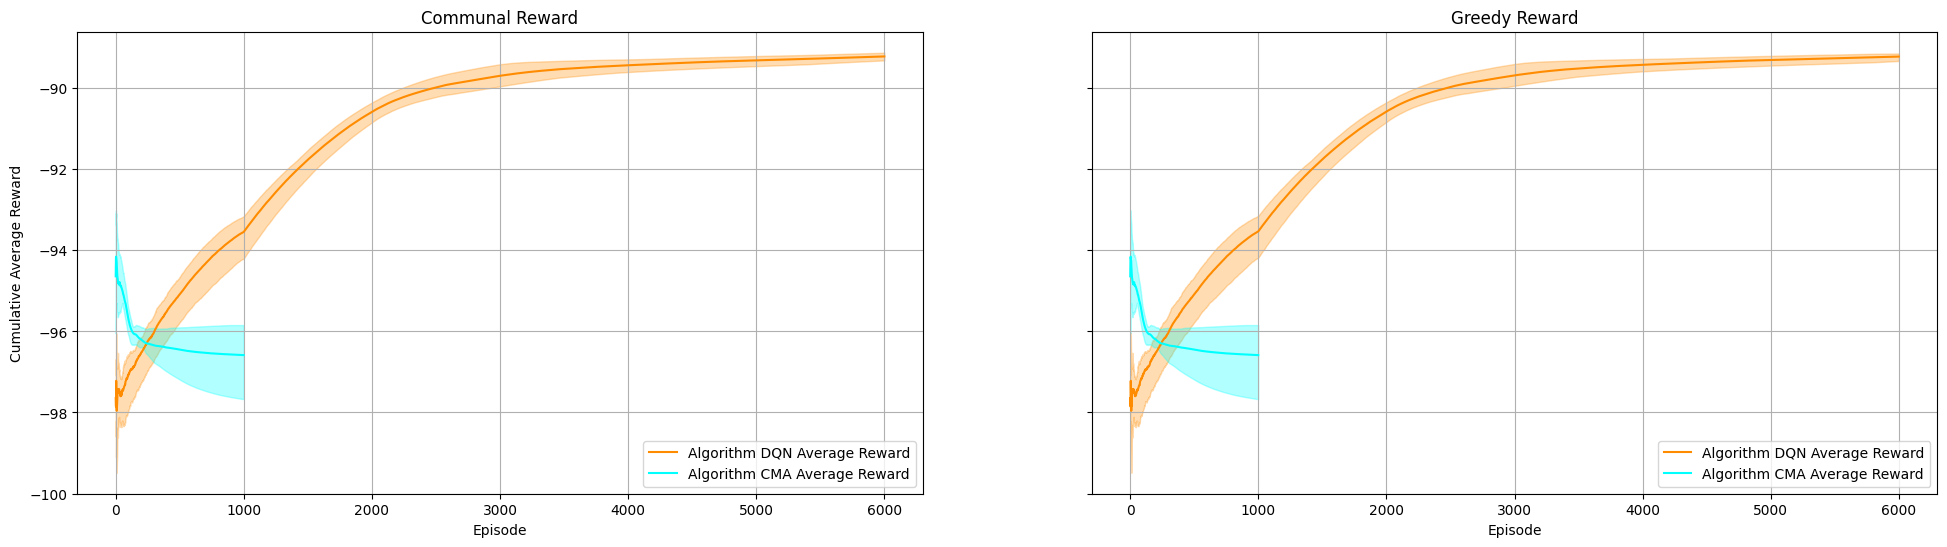

In [6]:
num_plots = len(cumulative_avg_reward_by_algorithm['reward_type'].unique())

fig, axes = plt.subplots(1, num_plots, figsize=(24, 6), sharey=True)  # Adjust figsize as needed

for plot_ind, reward_type in enumerate(cumulative_avg_reward_by_algorithm['reward_type'].unique()):
    ax = axes[plot_ind]
    
    reward_type_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['reward_type'] == reward_type]
        
    for algo in reward_type_data['algorithm'].unique():
        # Filter the data for the current zone
        algo_data = reward_type_data[reward_type_data['algorithm'] == algo]
        
        min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
        max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
        mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
    
        ax.fill_between(
            min_cumulative_avg_reward.index, 
            min_cumulative_avg_reward.values, 
            max_cumulative_avg_reward.values,
            color=colors[algo],
            alpha=0.3
        )
        ax.plot(
            mean_cumulative_avg_reward.index, 
            mean_cumulative_avg_reward.values,
            color=colors[algo],
            label=f'Algorithm {algo} Average Reward'
        )
    
    ax.set_xlabel('Episode')
    axes[0].set_ylabel('Cumulative Average Reward')
    ax.set_title('Greedy Reward' if reward_type == 'greedy' else 'Communal Reward')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.show()

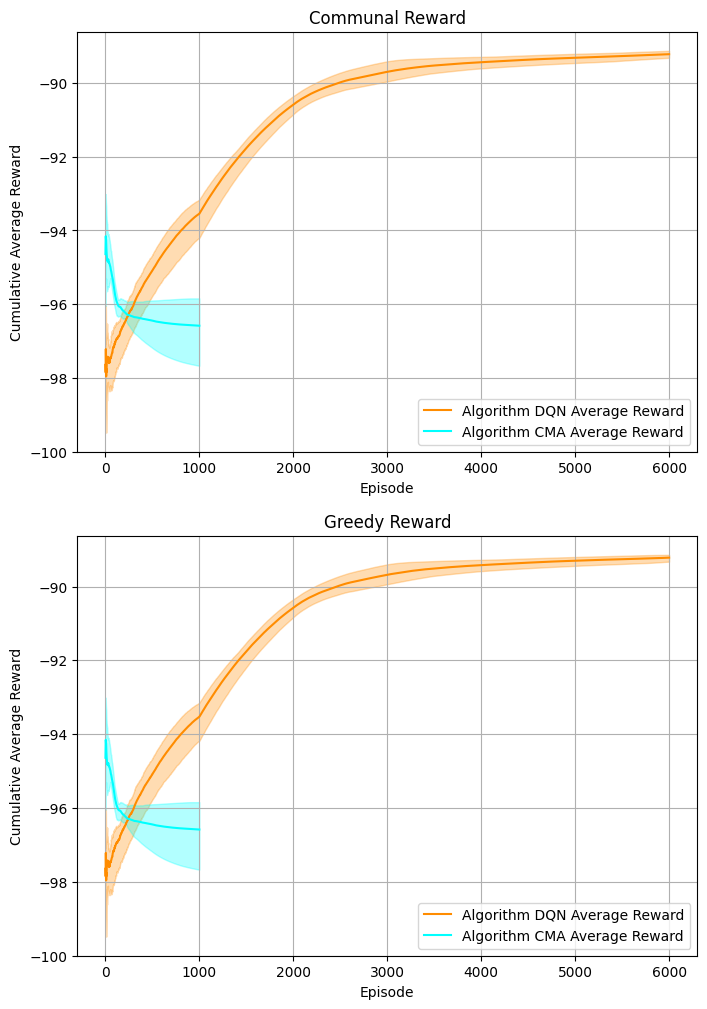

In [7]:
num_plots = len(cumulative_avg_reward_by_algorithm['reward_type'].unique())

fig, axes = plt.subplots(num_plots, 1, figsize=(8, 12))  # Adjust figsize as needed

for plot_ind, reward_type in enumerate(cumulative_avg_reward_by_algorithm['reward_type'].unique()):
    ax = axes[plot_ind]
    
    reward_type_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['reward_type'] == reward_type]
        
    for algo in reward_type_data['algorithm'].unique():
        # Filter the data for the current zone
        algo_data = reward_type_data[reward_type_data['algorithm'] == algo]
        
        min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
        max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
        mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
    
        ax.fill_between(
            min_cumulative_avg_reward.index, 
            min_cumulative_avg_reward.values, 
            max_cumulative_avg_reward.values,
            color=colors[algo],
            alpha=0.3
        )
        ax.plot(
            mean_cumulative_avg_reward.index, 
            mean_cumulative_avg_reward.values,
            color=colors[algo],
            label=f'Algorithm {algo} Average Reward'
        )
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.set_title('Greedy Reward' if reward_type == 'greedy' else 'Communal Reward')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.show()